<a href="https://colab.research.google.com/github/Oleksii-Adamov/text-detection-recognition-project/blob/main/Kirill_notebooks/visualisation_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install git+https://github.com/paulgavrikov/visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-n1byjqc6
  Running command git clone -q https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-n1byjqc6
     |████████████████████████████████| 989 kB 8.0 MB/s 
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13449 sha256=5021cfb96955ecfa8ccf187ee51e3507f8a8996b1c8a63fb914d610ea8bd120e
  Stored in directory: /tmp/pip-ephem-wheel-cache-hucds75d/wheels/b8/3b/cf/30a062e766188d5fe50abf3d461720943b7d09906e3d261a94
Successfully built visualkeras


In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, InputLayer, ZeroPadding2D, Permute, Lambda
import tensorflow as tf
from tensorflow import keras
from collections import defaultdict
import visualkeras
from PIL import ImageFont
import numpy as np

In [ ]:
def make_vgg_block(x, filters, n, prefix, pooling=True):
    x = keras.layers.Conv2D(filters=filters,strides=(1, 1),kernel_size=(3, 3),padding="same",name=f"{prefix}.{n}",)(x)
    x = keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5, axis=-1, name=f"{prefix}.{n+1}")(x)
    x = keras.layers.Activation("relu", name=f"{prefix}.{n+2}")(x)
    if pooling:
        x = keras.layers.MaxPooling2D(pool_size=(2, 2), padding="valid", strides=(2, 2), name=f"{prefix}.{n+3}")(x)
    return x

In [ ]:
def build_vgg_backbone(inputs):
    x = make_vgg_block(inputs, filters=64, n=0, pooling=False, prefix="basenet.slice1")
    x = make_vgg_block(x, filters=64, n=3, pooling=True, prefix="basenet.slice1")
    x = make_vgg_block(x, filters=128, n=7, pooling=False, prefix="basenet.slice1")
    x = make_vgg_block(x, filters=128, n=10, pooling=True, prefix="basenet.slice1")
    x = make_vgg_block(x, filters=256, n=14, pooling=False, prefix="basenet.slice2")
    x = make_vgg_block(x, filters=256, n=17, pooling=False, prefix="basenet.slice2")
    x = make_vgg_block(x, filters=256, n=20, pooling=True, prefix="basenet.slice3")
    x = make_vgg_block(x, filters=512, n=24, pooling=False, prefix="basenet.slice3")
    x = make_vgg_block(x, filters=512, n=27, pooling=False, prefix="basenet.slice3")
    x = make_vgg_block(x, filters=512, n=30, pooling=True, prefix="basenet.slice4")
    x = make_vgg_block(x, filters=512, n=34, pooling=False, prefix="basenet.slice4")
    x = make_vgg_block(x, filters=512, n=37, pooling=False, prefix="basenet.slice4")
    x = make_vgg_block(x, filters=512, n=40, pooling=True, prefix="basenet.slice4")
    vgg = keras.models.Model(inputs=inputs, outputs=x)
    return [
        vgg.get_layer(slice_name).output
        for slice_name in [
            "basenet.slice1.12",
            "basenet.slice2.19",
            "basenet.slice3.29",
            "basenet.slice4.38",
        ]
    ]

In [ ]:
def upconv(x, n, filters):
    x = keras.layers.Conv2D(filters=filters, kernel_size=1, strides=1, name=f"upconv{n}.conv.0")(x)
    x = keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.9, name=f"upconv{n}.conv.1")(x)
    x = keras.layers.Activation("relu", name=f"upconv{n}.conv.2")(x)
    x = keras.layers.Conv2D(filters=filters // 2,kernel_size=3,strides=1,padding="same",name=f"upconv{n}.conv.3",)(x)
    x = keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.9, name=f"upconv{n}.conv.4")(x)
    x = keras.layers.Activation("relu", name=f"upconv{n}.conv.5")(x)
    return x

In [ ]:
class UpsampleLike(keras.layers.Layer):
    """Keras layer for upsampling a Tensor to be the same shape as another Tensor."""

    # pylint:disable=unused-argument
    def call(self, inputs, **kwargs):
        source, target = inputs
        target_shape = keras.backend.shape(target)
        if keras.backend.image_data_format() == "channels_first":
            raise NotImplementedError
        else:
            # pylint: disable=no-member
            return tf.compat.v1.image.resize_bilinear(
                source, size=(target_shape[1], target_shape[2]), half_pixel_centers=True
            )

    def compute_output_shape(self, input_shape):
        if keras.backend.image_data_format() == "channels_first":
            raise NotImplementedError
        else:
            return (input_shape[0][0],) + input_shape[1][1:3] + (input_shape[0][-1],)

In [ ]:
backbone_name="vgg"
weights_path = None
inputs = keras.layers.Input((100, 100, 3))

s1, s2, s3, s4 = build_vgg_backbone(inputs)

s5 = keras.layers.MaxPooling2D(pool_size=3, strides=1, padding="same", name="basenet.slice5.0")(s4)
s5 = keras.layers.Conv2D(1024,kernel_size=(3, 3),padding="same",strides=1,dilation_rate=6,name="basenet.slice5.1",)(s5)
s5 = keras.layers.Conv2D(1024, kernel_size=1, strides=1, padding="same", name="basenet.slice5.2")(s5)

y = keras.layers.Concatenate()([s5, s4])
y = upconv(y, n=1, filters=512)
y = UpsampleLike()([y, s3])

y = keras.layers.Concatenate()([y, s3])
y = upconv(y, n=2, filters=256)
y = UpsampleLike()([y, s2])

y = keras.layers.Concatenate()([y, s2])
y = upconv(y, n=3, filters=128)
y = UpsampleLike()([y, s1])

y = keras.layers.Concatenate()([y, s1])
features = upconv(y, n=4, filters=64)

y = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", name="conv_cls.0")(features)
y = keras.layers.Activation("relu", name="conv_cls.1")(y)

y = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", name="conv_cls.2")(y)
y = keras.layers.Activation("relu", name="conv_cls.3")(y)

y = keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", name="conv_cls.4")(y)
y = keras.layers.Activation("relu", name="conv_cls.5")(y)

y = keras.layers.Conv2D(filters=16, kernel_size=1, strides=1, padding="same", name="conv_cls.6")(y)
y = keras.layers.Activation("relu", name="conv_cls.7")(y)

y = keras.layers.Conv2D(filters=2, kernel_size=1, strides=1, padding="same", name="conv_cls.8")(y)

model = keras.models.Model(inputs=inputs, outputs=y)


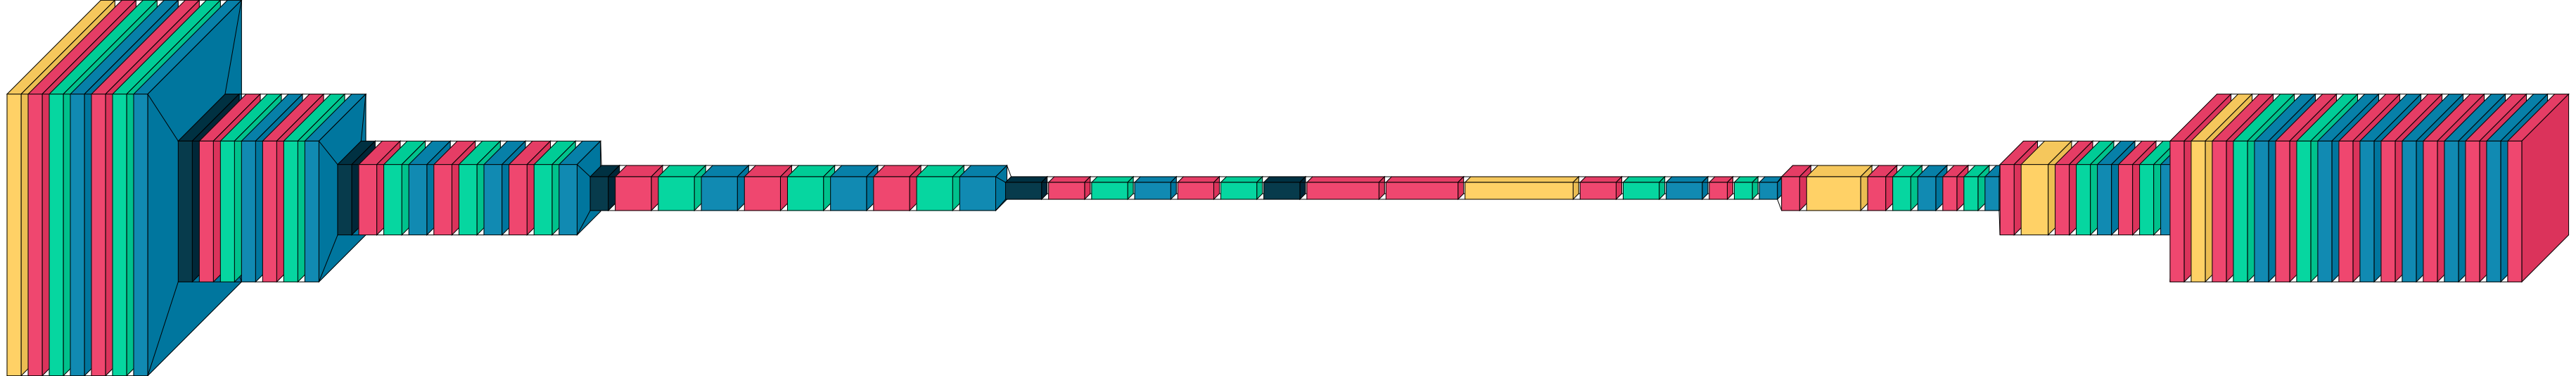

In [ ]:
visualkeras.layered_view(model, legend=False,  to_file='/content/figures/detect.png')